In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

env = gym.make("CarRacing-v0")
from pyglet import gl
import cProfile
_ = env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Track generation: 1235..1546 -> 311-tiles track


In [282]:
def choose_distribution(values, dist):
    latent = np.random.random()
    less = latent < dist
    more = latent > dist
    
    minimum = values[np.argmax(less)]
    maximum = np.flip(values, 0)[np.argmax(np.flip(more, 0))]
    #print(minimum, maximum)
    return np.random.uniform(minimum, maximum)


In [283]:
np.random.uniform(1, -1)

0.9951797130460622

In [301]:
def choose_random(w, N):
    return [env.action_space.sample() for _ in range(N)]

from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape



distribution_res = 40
control_values = np.linspace(-1, 1, distribution_res)

num_controls = 3

choose_model = Sequential([
    Dense(512, input_shape=(45 + 6,)),
    Activation('relu'),
    Dense(512),
    Activation('relu'),
    Dense(512),
    Activation('relu'),
    Dense(distribution_res * 3),
    Activation('sigmoid'),
    Reshape((3, distribution_res))
])

choose_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[])

def choose_network(w, N):
    action_distributions = choose_model.predict(w)[0]
    actions = [
        np.array([
            choose_distribution(control_values, ad) 
            for ad in action_distributions
        ])
        for _ in range(N)
    ]
    return actions
    

In [284]:
predict_model = Sequential([
    Dense(512, input_shape=(45 + 9,)),
    Activation('relu'),
    Dense(512),
    Activation('relu'),
    Dense(512),
    Activation('relu'),
    Dense(15 + 1),
    Activation('tanh')
])

predict_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[])


def predict(w, N):
    world_distributions = predict_model.predict(np.concatenate([w], 1))[0]
    new_ws = [
        np.array([
            choose_distribution(wd, control_values) 
            for wd in world_distributions
        ])
        for _ in range(N)
    ]
    return new_ws

In [202]:
%%time
_ = env.reset()
done = False

obs_l = []
reward_l = []
action_l = []
action = [0, 1, .4]
while not done:
    
    obs, reward, done, _ = env.step(action)
    action_l.append(action)
    obs_l.append(obs)
    reward_l.append(reward)
    if (len(reward_l) % 8 == 0):
        env.render()

Track generation: 1224..1534 -> 310-tiles track
CPU times: user 2.54 s, sys: 112 ms, total: 2.66 s
Wall time: 2.95 s


In [16]:
import pickle
pca = pickle.load(open("pca3", "rb"))

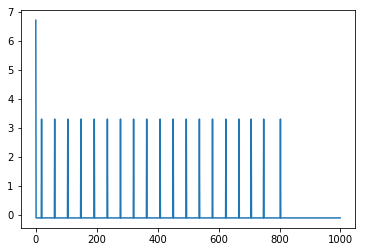

In [18]:
plt.plot(reward_l)
plt.show()

In [19]:
obs_array = np.array([o.flatten() for o in obs_l])

In [20]:
obs_array.shape

(1000, 27648)

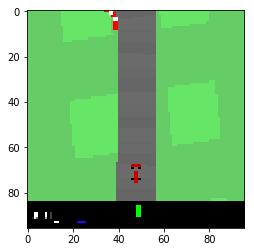

In [21]:
plt.imshow(obs_array[189].reshape(96, 96, 3))

In [22]:
#from sklearn.decomposition import PCA
#pca2 = PCA(n_components=15)
#pca2.fit(obs_array)

In [23]:
pca.explained_variance_ratio_

array([0.13465523, 0.09625685, 0.07986641, 0.05644728, 0.04304   ,
       0.03629665, 0.03023207, 0.02547132, 0.02038278, 0.01962681,
       0.01851783, 0.01684963, 0.0160569 , 0.01437757, 0.01244982])

In [24]:
pca.explained_variance_ratio_

array([0.13465523, 0.09625685, 0.07986641, 0.05644728, 0.04304   ,
       0.03629665, 0.03023207, 0.02547132, 0.02038278, 0.01962681,
       0.01851783, 0.01684963, 0.0160569 , 0.01437757, 0.01244982])

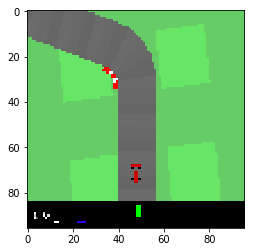

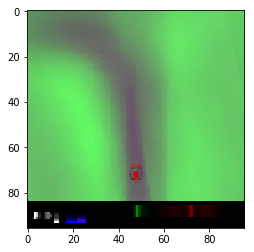

In [204]:
i = 400
plt.imshow(obs_array[i].reshape((96, 96, 3)))
plt.show()
#plt.imshow(np.clip( pca.inverse_transform().reshape(96, 96, 3)/ 256, 0, 1))


def render(W):
    plt.imshow(np.clip( pca.inverse_transform(W * 9000).reshape(96, 96, 3)/ 256, 0, 1))
    plt.show()
render(pca.transform(np.expand_dims(obs_array[i], 0)) / 9000)

In [29]:
V_features = pca.transform(obs_array) / 9000

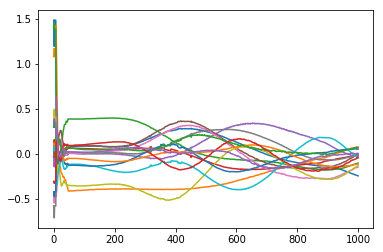

In [30]:
plt.plot(V_features)
plt.show()

In [20]:
import keras

Using TensorFlow backend.


In [89]:
aug_features = V_features
#aug_features = np.concatenate([V_features, V_features**2, V_features**3], -1)

In [90]:
aug_features = np.concatenate([aug_features[:-3], aug_features[1:-2], aug_features[2:-1]], -1)

In [91]:
aug_features[0, -15:] - V_features[2:][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [92]:
train_predict_features = np.concatenate([aug_features, action_l[3:]], 1)

In [93]:
train_predict_y = np.concatenate([V_features[3:], np.expand_dims(reward_l[3:], 1)], 1)

In [98]:
train_predict_y.shape

(997, 16)

In [268]:
def arr_to_step(arr):
    arr2 = np.expand_dims(arr, -1)
    values_step = np.expand_dims(np.expand_dims(control_values, 0), 0)
    print(arr2.shape)
    print(values_step.shape)
    return arr2 < values_step
y = arr_to_step(train_predict_y)
y

(997, 16, 1)
(1, 1, 40)


array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  Tr

In [146]:
predict_model.fit(train_predict_features, train_predict_y, epochs=30)

Epoch 1/30
997/997 [==============================] - 1s 639us/step - loss: 0.0186
Epoch 2/30
997/997 [==============================] - 0s 400us/step - loss: 0.0148
Epoch 3/30
997/997 [==============================] - 0s 391us/step - loss: 0.0145
Epoch 4/30
997/997 [==============================] - 0s 387us/step - loss: 0.0146
Epoch 5/30
997/997 [==============================] - 0s 412us/step - loss: 0.0145
Epoch 6/30
997/997 [==============================] - 0s 395us/step - loss: 0.0143
Epoch 7/30
997/997 [==============================] - 0s 423us/step - loss: 0.0141
Epoch 8/30
997/997 [==============================] - 0s 415us/step - loss: 0.0142
Epoch 9/30
997/997 [==============================] - 0s 395us/step - loss: 0.0140
Epoch 10/30
997/997 [==============================] - 0s 391us/step - loss: 0.0141
Epoch 11/30
997/997 [==============================] - 0s 401us/step - loss: 0.0143
Epoch 12/30
997/997 [==============================] - 0s 411us/step - loss: 0.0140
E

In [138]:
train_predict_y

array([[ 1.48693458,  1.08331046,  1.38875575, ..., -0.30423569,
         0.35318927, -0.1       ],
       [ 1.48693458,  1.08331046,  1.38875575, ..., -0.30423569,
         0.35318927, -0.1       ],
       [ 1.48693458,  1.08331046,  1.38875575, ..., -0.30423569,
         0.35318927, -0.1       ],
       ...,
       [-0.2395642 ,  0.08025666, -0.10291432, ..., -0.0410221 ,
         0.00785439, -0.1       ],
       [-0.24105402,  0.08066457, -0.10165663, ..., -0.03908361,
         0.00803129, -0.1       ],
       [-0.24220144,  0.07957955, -0.09972222, ..., -0.03852405,
         0.00737826, -0.1       ]])

In [151]:
predict_model.predict(train_predict_features[101:102]) - train_predict_y[101]

array([[ 0.00063425,  0.00332721,  0.00945852, -0.00171296,  0.00210506,
         0.00284824, -0.00740791,  0.00748527, -0.01353528, -0.00103671,
         0.0032264 , -0.0018211 ,  0.00426148,  0.00119898,  0.00553221,
         0.06043443]])

In [173]:
t = train_predict_features[101:102].copy()
t[0, -3] = -1

(1, 45)


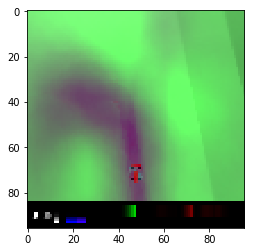

ValueError: Error when checking : expected dense_69_input to have shape (54,) but got array with shape (45,)

In [298]:
def step(W):
    newW = predict_model.predict(W)                 
    Wn = np.concatenate([W[:, 18:], newW[:, :-1], np.zeros((1, 3))], 1)
    #render(newW[:, :15])
    return(Wn, newW[:, 15])
W = aug_features[700:701].copy()
print(W.shape)
render(W[:, 30:45])
for _ in range(10):
    W, reward  = step(W)
    print(reward)

In [315]:
def features(obs):
    V_features_now = pca.transform(np.array([obs.flatten()])) / 9000
    #aug_features = np.concatenate([V_features_now, V_features_now**2, V_features_now**3], -1)
    return V_features_now
#run_l = []
for _ in range(200):
    obs = env.reset()
    V_features_now = features(obs)
    #print(V_features_now)
    done = False
    #print(V_features_now.shape)
    feature_stack = [np.concatenate
                
                     ([V_features_now, np.zeros((1, 3))], 1)] * 3

    reward_l = []
    action_l = []
    while not done:
        W = np.expand_dims(np.array(feature_stack[-3:]).flatten(), 0)
        predicted_reward = -1000
        for test_action in choose_network(W[:, :51], 10):

            Wh = W.copy()
            interm_action = test_action
            reward = 0
            for _ in range(9):
                
                Wh[:, 3 * 18 - 3:] = interm_action
                Wh, r = step(Wh)
                interm_action = choose_network(Wh[:, :51], 1)[0]
                reward+= r

            if  (reward  > predicted_reward):
                action = test_action
                predicted_reward = reward

        feature_stack[-1][0][-3:] = action
        obs, reward, done, _ = env.step(action)
        V_features_now = features(obs)
        action_l.append(action)
        #obs_l.append(obs)
        reward_l.append(reward)
        env.render()
        feature_stack.append(np.concatenate([V_features_now, np.zeros((1, 3))], 1))
    run_l.append((feature_stack, action_l, reward_l))
    feature_stack = np.array(feature_stack)
    print(feature_stack[3:-1, 0].shape, np.expand_dims(reward_l[:-1], 1).shape)
    x_features = np.concatenate([feature_stack[:-4, 0], 
                                   feature_stack[1:-3, 0], 
                                   feature_stack[2:-2, 0], ], -1)

    y_features = np.concatenate([feature_stack[3:-1, 0, :15], 
                                 np.expand_dims(reward_l[:-1], 1)], -1)
    predict_model.fit(x_features, y_features)
    choose_model.fit(x_features[:, :51], arr_to_step(x_features[:, 51:]))




Track generation: 1104..1392 -> 288-tiles track
(999, 18) (999, 1)
Epoch 1/1
999/999 [==============================] - 0s 384us/step - loss: 0.0258
(999, 3, 1)
(1, 1, 40)
Epoch 1/1
999/999 [==============================] - 0s 399us/step - loss: 0.1002
Track generation: 1107..1388 -> 281-tiles track
(999, 18) (999, 1)
Epoch 1/1
999/999 [==============================] - 0s 372us/step - loss: 0.0205
(999, 3, 1)
(1, 1, 40)
Epoch 1/1
999/999 [==============================] - 0s 383us/step - loss: 0.0912
Track generation: 1164..1466 -> 302-tiles track


KeyboardInterrupt: 

In [309]:
feature_stack


[array([[ 1.87927094,  0.50984364,  0.17507082, -0.03491651, -0.01267693,
         -0.25543419, -0.01708192,  0.25365384, -0.04024211,  0.07844771,
          0.25945301, -0.16042367,  0.11030194,  0.16239812, -0.17075183,
         -0.74534708,  0.0295021 ,  0.43817797]]),
 array([[ 1.87927094,  0.50984364,  0.17507082, -0.03491651, -0.01267693,
         -0.25543419, -0.01708192,  0.25365384, -0.04024211,  0.07844771,
          0.25945301, -0.16042367,  0.11030194,  0.16239812, -0.17075183,
         -0.74534708,  0.0295021 ,  0.43817797]]),
 array([[ 1.87927094,  0.50984364,  0.17507082, -0.03491651, -0.01267693,
         -0.25543419, -0.01708192,  0.25365384, -0.04024211,  0.07844771,
          0.25945301, -0.16042367,  0.11030194,  0.16239812, -0.17075183,
         -0.74534708,  0.0295021 ,  0.43817797]]),
 array([[ 1.70659776,  0.54443545,  0.22304446, -0.00713358, -0.11242423,
          0.03465282, -0.02108603,  0.19536818, -0.04909609,  0.01365845,
          0.12851275, -0.26317417

In [256]:
x_features[2:, 15:30] - y_features[:-2, :-1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [259]:
x_features[:, 45:] - action_l[:-1]


array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [260]:
choose_model.fit(x_features[:, :45], arr_to_step(x_features[:, 45:]))

(999, 3, 1)
(1, 1, 40)
Epoch 1/1
999/999 [==============================] - 1s 703us/step - loss: 0.1910


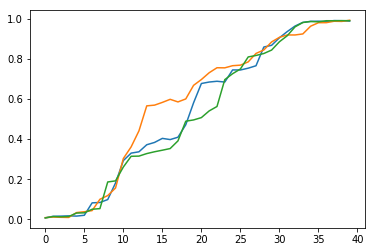

In [278]:
plt.plot(choose_model.predict(W)[0].transpose())


In [279]:
choose_network(W, 6)

[array([-0.06918232,  0.71431494, -0.29902644]),
 array([ 0.21905344, -0.3935307 ,  0.49321322]),
 array([-0.04180111, -0.46992379, -0.49436521]),
 array([-0.08012646, -0.37603005,  0.31424778]),
 array([-0.50454906,  0.93107439, -0.59260363]),
 array([-0.61317842,  0.49063962, -0.10750587])]

In [214]:
pickle.dump(obs_l, open("obs_l5", "wb"))

In [215]:
pickle.dump(gene_pool, open("gene_pool5", "wb"))
def normalize(vec):
    vec = vec - np.min(vec)
    vec /= np.max(vec
                 )
    return vec

In [4]:
def features(obs):
    V_features_now = pca.transform(np.array([obs.flatten()])) / 9000
    #aug_features = np.concatenate([V_features_now, V_features_now**2, V_features_now**3], -1)
    return V_features_now
env = gym.make("CarRacing-v0")
#def runout(policy):
action_l = []
for _ in range(200):
    obs = env.reset()
    V_features_now = features(obs)
    #print(V_features_now)
    done = False
    feature_stack = [V_features_now] * 3
    for _ in range(50):
        reward_l = []

        p_obs_l = []

        action_delta = (np.random.random(3) - .5) * .05
        for _ in range(20):

            processed_obs = np.concatenate([np.array(feature_stack[-3:]).flatten(), np.ones(5)])
            p_obs_l.append(processed_obs)
            


            action = np.tanh(np.dot(processed_obs, policy) + action_delta)
            action_l.append(action)

            obs, reward, done, _ = env.step(action)
            V_features_now = features(obs)
            action_l.append(action)
            #obs_l.append(obs)
            reward_l.append(reward)
            env.render()
            feature_stack.append(V_features_now)
        assigned_reward = np.convolve(.9**np.arange(50, 0, -1), reward_l, "full")[-len(reward_l):]
        print (np.sum(reward_l))
        print (policy)
        for i in range(20):
            reward = assigned_reward[i]
            contribs = policy * np.expand_dims(p_obs_l[i], -1)
            direction= action_delta

            policy -= reward * contribs * np.expand_dims(direction, 0)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Track generation: 1226..1536 -> 310-tiles track


NameError: name 'pca' is not defined

In [122]:
assigned_reward = np.convolve(.9**np.arange(50, 0, -1), reward_l, "full")[-len(reward_l):]
for i in range(1000):
    reward = assigned_reward[i]
    contribs = policy * np.expand_dims(p_obs_l[i], -1)
    direction= action_delta_l[i]
    
    policy -= .01 * reward * contribs * np.expand_dims(direction, 0)

In [98]:
np.convolve?

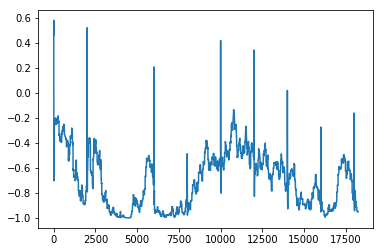

In [143]:
plt.plot(np.array(action_l)[:, 1])

In [3]:
list(np.arange(8))

[0, 1, 2, 3, 4, 5, 6, 7]

In [179]:
reward = [o[2] for o in obs_l]

In [91]:
reward = np.array(reward)

In [165]:
len(obs_l)

204

In [97]:
reward[:, 0]

IndexError: too many indices for array

In [200]:
reward = [np.sum(o[2]) for o in obs_l]
reward.append(0)

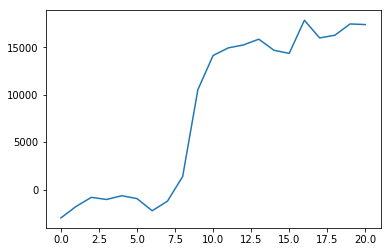

In [205]:
plt.plot(np.sum(np.array(reward).reshape((-1, 40)), 1))

In [193]:
os, actions, rewards = obs_l[751]

IndexError: list index out of range

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

#=========================================
# Create Fake Images using Numpy 
# You don't need this in your code as you have your own imageList.
# This is used as an example.

imageList = []
for i in range(0, 1000, 5):
    
    imageList.append(
        np.clip( pca.inverse_transform(os[i] * 9000).reshape(96, 96, 3)/ 256, 0, 1))

#=========================================
# Animate Fake Images (in Jupyter)

def getImageFromList(x):
    return imageList[x]

fig = plt.figure(figsize=(10, 10))
ims = []
for i in range(len(imageList)):
    im = plt.imshow(getImageFromList(i), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
plt.close()

# Show the animation
HTML(ani.to_html5_video())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


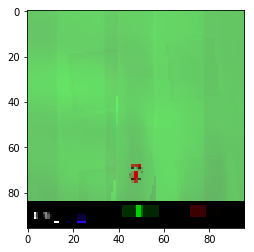

In [212]:
if 1:
    from pyglet.window import key
    a = np.array( [0.0, 0.0, 0.0] )
    def key_press(k, mod):
        global restart
        if k==0xff0d: restart = True
        if k==key.LEFT:  a[0] = -1.0
        if k==key.RIGHT: a[0] = +1.0
        if k==key.UP:    a[1] = +1.0
        if k==key.DOWN:  a[2] = +0.8   # set 1.0 for wheels to block to zero rotation
    def key_release(k, mod):
        if k==key.LEFT  and a[0]==-1.0: a[0] = 0
        if k==key.RIGHT and a[0]==+1.0: a[0] = 0
        if k==key.UP:    a[1] = 0
        if k==key.DOWN:  a[2] = 0
    env = env.unwrapped
    env.render()
    record_video = False
    if record_video:
        env.monitor.start('/tmp/video-test', force=True)
    env.viewer.window.on_key_press = key_press
    env.viewer.window.on_key_release = key_release
    while True:
        env.reset()
        total_reward = 0.0
        steps = 0
        restart = False
        while True:
            s, r, done, info = env.step(a)
            total_reward += r
            if steps % 200 == 0 or done:
                print("\naction " + str(["{:+0.2f}".format(x) for x in a]))
                print("step {} total_reward {:+0.2f}".format(steps, total_reward))
                #import matplotlib.pyplot as plt
                #plt.imshow(s)
                #plt.savefig("test.jpeg")
            steps += 1
            if not record_video: # Faster, but you can as well call env.render() every time to play full window.
                env.render()
            if done or restart: break
    env.close()


Track generation: 1206..1512 -> 306-tiles track

action ['+0.00', '+0.00', '+0.00']
step 0 total_reward +6.46

action ['+0.00', '+0.00', '+0.00']
step 200 total_reward +2.85

action ['-1.00', '+0.00', '+0.00']
step 400 total_reward +25.47

action ['+0.00', '+1.00', '+0.00']
step 600 total_reward +38.26

action ['+0.00', '+1.00', '+0.00']
step 800 total_reward +54.33

action ['+0.00', '+1.00', '+0.00']
step 1000 total_reward +57.28

action ['+1.00', '+0.00', '+0.00']
step 1200 total_reward +37.28

action ['+0.00', '+0.00', '+0.00']
step 1400 total_reward +17.28

action ['+0.00', '+0.00', '+0.00']
step 1600 total_reward -2.72

action ['+0.00', '+0.00', '+0.00']
step 1800 total_reward +19.90

action ['+0.00', '+0.00', '+0.00']
step 2000 total_reward +108.10

action ['+0.00', '+0.00', '+0.00']
step 2200 total_reward +186.46

action ['-1.00', '+0.00', '+0.00']
step 2400 total_reward +258.26

action ['-1.00', '+0.00', '+0.00']
step 2600 total_reward +320.23

action ['+1.00', '+0.00', '+0.00'

KeyboardInterrupt: 